In [1]:
%matplotlib inline
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.scipy.special import expit
from jax.scipy.stats import bernoulli, norm

from samplers import get_min_ess, make_samplers

In [2]:
@jax.jit
def joint_energy(q_hmc, q_other):
    return (
        -norm.logpdf(q_hmc[0])
        - norm.logpdf(q_hmc[1], loc=q_hmc[0], scale=0.04)
        - jnp.sum(bernoulli.logpmf(q_other, p=expit(-q_hmc[0])))
    )


@jax.jit
def sample_q_other(q_hmc, key):
    key, subkey = jax.random.split(key)
    q_other = jax.random.bernoulli(subkey, p=expit(-q_hmc[0]), shape=(20,))
    return q_other, key


(
    mala_within_gibbs,
    hmc_within_gibbs,
    mahmc_within_gibbs,
    mala_persistent_within_gibbs,
    mala_persistent_nonreversible_within_gibbs,
) = make_samplers(joint_energy, sample_q_other)

In [3]:
n_samples, n_warm_up_samples = int(1e6), int(1e5)
L = 10
n_chains = 16

# MALA within Gibbs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6647.07it/s]



### MALA-within-Gibbs, epsilon: 0.03

u_ess: 0.0010697373342752347
acceptance: 0.46603378653526306




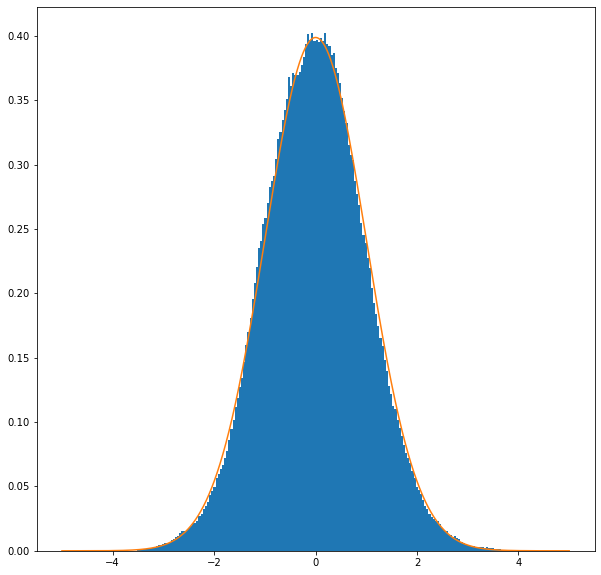

In [4]:
epsilon = 0.03


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None), out_axes=0)
def get_mala_within_gibbs_samples(key, epsilon):
    def scan_f(carry, ii):
        uv, w, key = carry
        uv, w, key, accept = mala_within_gibbs(uv, w, key, epsilon, L)
        return (uv, w, key), (uv, w, accept)

    key, subkey = jax.random.split(key)
    uv = jax.random.normal(subkey, shape=(2,))
    uv = uv.at[1].set((uv[1] + uv[0]) * 0.04)
    key, subkey = jax.random.split(key)
    w = jax.random.bernoulli(subkey, shape=(20,))
    _, samples = jax.lax.scan(scan_f, (uv, w, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mala_within_gibbs_samples(keys, epsilon)
print(
    f"""
### MALA-within-Gibbs, epsilon: {epsilon}

u_ess: {get_min_ess(samples[0].copy()[..., [0]])}
acceptance: {np.mean(samples[2])}

"""
)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(samples[0][0, ..., 0].copy(), bins=200, density=True)
x = np.linspace(-5, 5, int(1e5))
ax.plot(x, norm.pdf(x))

# HMC-within-Gibbs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6159.04it/s]



### HMC-within-Gibbs, N: 4, epsilon: 0.035

u_ess: 0.04658477945213101
acceptance: 0.995808482170105




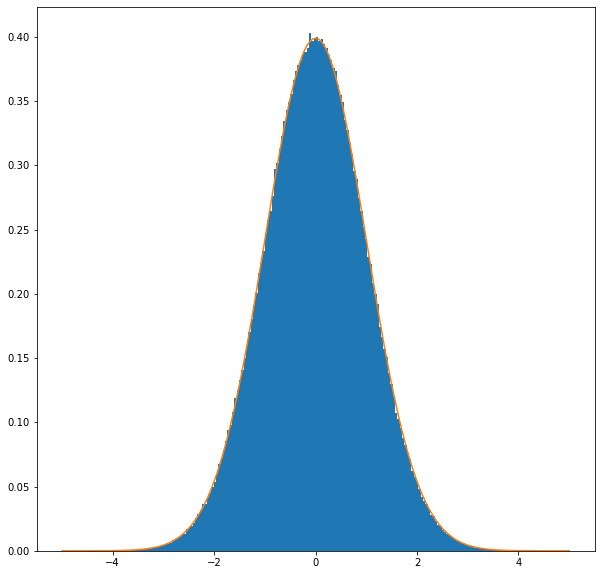

In [5]:
N = 4
epsilon = 0.035


@functools.partial(jax.jit, static_argnames="N")
@functools.partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def get_hmc_within_gibbs_samples(key, N, epsilon):
    def scan_f(carry, ii):
        uv, w, key = carry
        uv, w, key, accept = hmc_within_gibbs(uv, w, key, epsilon, L * N)
        return (uv, w, key), (uv, w, accept)

    key, subkey = jax.random.split(key)
    uv = jax.random.normal(subkey, shape=(2,))
    uv = uv.at[1].set((uv[1] + uv[0]) * 0.04)
    key, subkey = jax.random.split(key)
    w = jax.random.bernoulli(subkey, shape=(20,))
    _, samples = jax.lax.scan(scan_f, (uv, w, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_hmc_within_gibbs_samples(keys, N, epsilon)
print(
    f"""
### HMC-within-Gibbs, N: {N}, epsilon: {epsilon}

u_ess: {get_min_ess(samples[0].copy()[..., [0]]) / N}
acceptance: {np.mean(samples[2])}

"""
)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(samples[0][0, ..., 0].copy(), bins=200, density=True)
x = np.linspace(-5, 5, int(1e5))
ax.plot(x, norm.pdf(x))

# MAHMC

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]



### MAHMC-within-Gibbs, N: 10, epsilon: 0.04

u_ess: 0.17811700414936876
acceptance: 0.9541751146316528




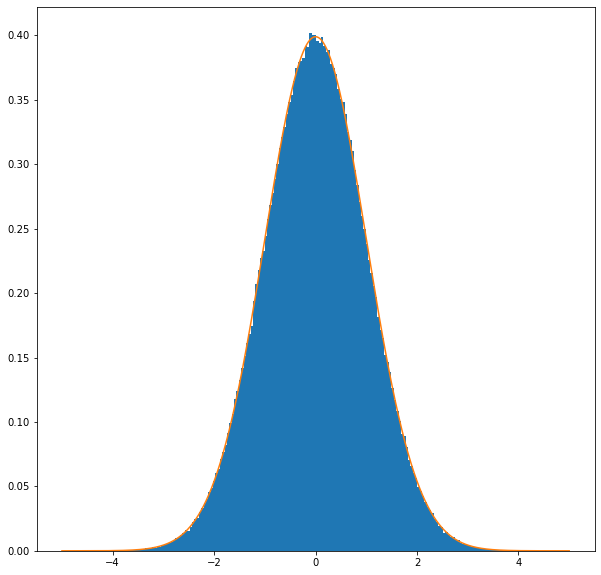

In [6]:
N = 10
epsilon = 0.04


@functools.partial(jax.jit, static_argnames="N")
@functools.partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def get_mahmc_within_gibbs_samples(key, N, epsilon):
    def scan_f(carry, ii):
        uv, w, key = carry
        uv, w, key, accept = mahmc_within_gibbs(uv, w, key, epsilon, L, N)
        return (uv, w, key), (uv, w, accept)

    key, subkey = jax.random.split(key)
    uv = jax.random.normal(subkey, shape=(2,))
    uv = uv.at[1].set((uv[1] + uv[0]) * 0.04)
    key, subkey = jax.random.split(key)
    w = jax.random.bernoulli(subkey, shape=(20,))
    _, samples = jax.lax.scan(scan_f, (uv, w, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mahmc_within_gibbs_samples(keys, N, epsilon)
print(
    f"""
### MAHMC-within-Gibbs, N: {N}, epsilon: {epsilon}

u_ess: {get_min_ess(samples[0].copy()[..., [0]]) / N}
acceptance: {np.mean(samples[2])}

"""
)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(samples[0][0, ..., 0].copy(), bins=200, density=True)
x = np.linspace(-5, 5, int(1e5))
ax.plot(x, norm.pdf(x))

# MALA with persistent momentum

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5548.02it/s]



### MALA-P-within-Gibbs, epsilon: 0.03, alpha: 0.995

u_ess: 0.018300332901400797
acceptance: 0.46603378653526306




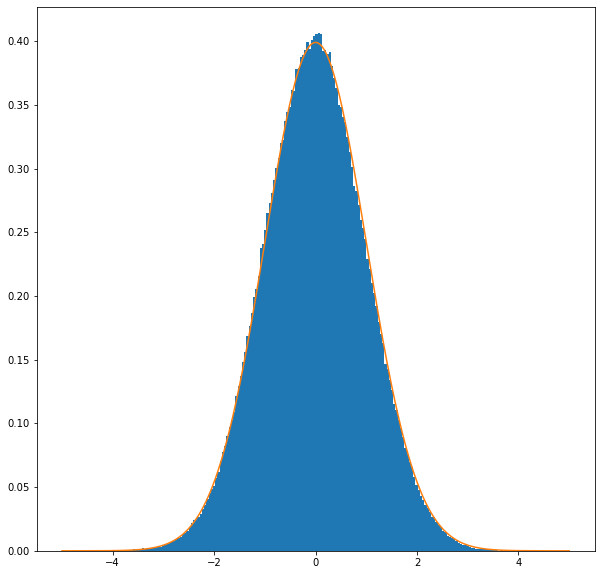

In [7]:
epsilon = 0.03
alpha = 0.995


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None), out_axes=0)
def get_mala_persistent_within_gibbs_samples(key, epsilon, alpha):
    def scan_f(carry, ii):
        uv, p, w, key = carry
        uv, p, w, key, accept = mala_persistent_within_gibbs(
            uv, p, w, key, epsilon, L, alpha
        )
        return (uv, p, w, key), (uv, w, accept)

    key, subkey = jax.random.split(key)
    uv = jax.random.normal(subkey, shape=(2,))
    uv = uv.at[1].set((uv[1] + uv[0]) * 0.04)
    key, subkey = jax.random.split(key)
    w = jax.random.bernoulli(subkey, shape=(20,))
    key, subkey = jax.random.split(key)
    p = jax.random.normal(subkey, shape=uv.shape)
    _, samples = jax.lax.scan(scan_f, (uv, p, w, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mala_persistent_within_gibbs_samples(keys, epsilon, alpha)
print(
    f"""
### MALA-P-within-Gibbs, epsilon: {epsilon}, alpha: {alpha}

u_ess: {get_min_ess(samples[0].copy()[..., [0]])}
acceptance: {np.mean(samples[2])}

"""
)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(samples[0][0, ..., 0].copy(), bins=200, density=True)
x = np.linspace(-5, 5, int(1e5))
ax.plot(x, norm.pdf(x))

# MALA with persistent momentum and non-reversible Metropolis accept/reject

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6553.60it/s]



### MALA-P-N-within-Gibbs, epsilon: 0.03, alpha: 0.995, delta: 0.01

u_ess: 0.07399640335633847
acceptance: 0.46603378653526306




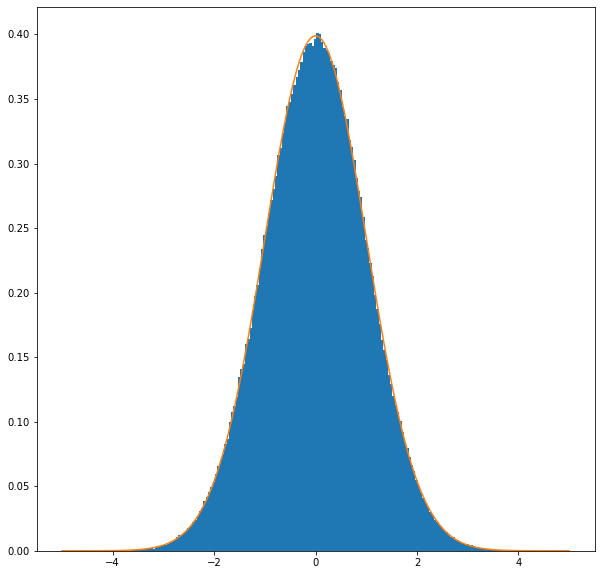

In [8]:
epsilon = 0.03
alpha = 0.995
delta = 0.01


@jax.jit
@functools.partial(jax.vmap, in_axes=(0, None, None, None), out_axes=0)
def get_mala_persistent_nonreversible_within_gibbs_samples(key, epsilon, alpha, delta):
    def scan_f(carry, ii):
        uv, p, w, v, key = carry
        uv, p, w, v, key, accept = mala_persistent_nonreversible_within_gibbs(
            uv, p, w, v, key, epsilon, L, alpha, delta
        )
        return (uv, p, w, v, key), (uv, w, accept)

    key, subkey = jax.random.split(key)
    uv = jax.random.normal(subkey, shape=(2,))
    uv = uv.at[1].set((uv[1] + uv[0]) * 0.04)
    key, subkey = jax.random.split(key)
    w = jax.random.bernoulli(subkey, shape=(20,))
    key, subkey = jax.random.split(key)
    p = jax.random.normal(subkey, shape=uv.shape)
    key, subkey = jax.random.split(key)
    v = jax.random.uniform(subkey) * 2 - 1
    _, samples = jax.lax.scan(scan_f, (uv, p, w, v, key), jnp.arange(n_samples))
    samples = jax.tree_util.tree_map(lambda x: x[n_warm_up_samples:], samples)
    return samples


key = jax.random.PRNGKey(np.random.randint(int(1e5)))
keys = jax.random.split(key, n_chains)
samples = get_mala_persistent_nonreversible_within_gibbs_samples(
    keys, epsilon, alpha, delta
)
print(
    f"""
### MALA-P-N-within-Gibbs, epsilon: {epsilon}, alpha: {alpha}, delta: {delta}

u_ess: {get_min_ess(samples[0].copy()[..., [0]])}
acceptance: {np.mean(samples[2])}

"""
)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(samples[0][0, ..., 0].copy(), bins=200, density=True)
x = np.linspace(-5, 5, int(1e5))
ax.plot(x, norm.pdf(x))